# KDM5C cis comparison

KDM5C encodes a protein that has five domains. Two domains are zinc fingers (DNA-binding motifs) and suggest that this protein is involved with regulating transcription and chromatin remodeling. See NCBI's webpage for more information: https://www.ncbi.nlm.nih.gov/gene/8242

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

In [2]:
def add_to_all_results(df, gene, omics, comparison, all_comp):
    expanded = df
    expanded['Gene'] = gene
    expanded['Comparison'] = comparison
    expanded['Omics'] = omics
    
    updated_all_comparisons = pd.concat([all_comp, expanded], sort=False)
    
    return updated_all_comparisons

In [3]:
 # get pval from dataframe or float 
def get_pval(results_df):
    if isinstance(results_df, pd.DataFrame):
        pval_series = results_df['P_Value']
        num_pval = float(pval_series[0])
        return num_pval
    else:
        return "Not Significant" # > 0.05

In [4]:
# Create boxplot and stripplot with pval annotation
def cis_plot(df, gene, omics_name, pval, mutation_type="Mutated"):
    omics_col = gene+"_"+omics_name
    
    # get right order for boxplots
    if mutation_type == "Mutated":
        comparison_list = ['Wildtype', 'Mutated']
    elif mutation_type == "Missense":
        comparison_list = ['Wildtype', 'Missense']
    elif mutation_type == "Truncation":
        comparison_list = ['Wildtype', 'Truncation']
        
    # get pval from dataframe or float 
    if isinstance(pval, pd.DataFrame):
        pval_series = pval['P_Value']
        num_pval = float(pval_series[0])
        str_pval = str(pval_series[0])
    elif isinstance(pval, float):
        num_pval = pval
        str_pval = str(pval)
        
    # Boxplot and Stripplot
    plt.rcParams['figure.figsize']=(8,5)
    sns.set(font_scale = 1.3)
    cis_boxplot = sns.boxplot(data = df, x = 'binary_mutations',
                              y = omics_col, order = comparison_list, showfliers = False)  
    cis_boxplot.set_title(
        gene + " Effect on " + gene +" "+omics_name.capitalize()+" in Kidney Tumors\n P-Value = "+str_pval[:6]+"\n")
    cis_boxplot = sns.stripplot(data= df, x = 'binary_mutations',
                                y = omics_col,jitter = True, color = ".3", order = comparison_list)
    cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = omics_name.capitalize())
    cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())
    
    # pval annotation
    bonferroni_cutoff = .05/6
    if num_pval <= bonferroni_cutoff:
        pval_symbol = "*"
    else:
        pval_symbol = "ns"
    
    x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
    y, h = df[omics_col].max() + .05, .05  
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color= '.3')
    plt.text((x1+x2)*.5,y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

    plt.show()
    plt.clf()
    plt.close()

## Step 2: Find the mutation frequency of KDM5C for Kidney Cancer

In [5]:
cancer = cptac.RenalCcrcc()
desired_cutoff = 0.1
gene = 'KDM5C'

freq_mut = al.get_frequently_mutated(cancer, cutoff = desired_cutoff)
freq_mut.loc[freq_mut['Gene'] == gene]

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
1,KDM5C,0.172727,0.036364,0.145455


## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

# Proteomics cis comparison

Proteomics: Mutated and Wildtype

In [6]:
prot_mut_status = f.format_cis_comparison_data(cancer, 'proteomics', gene)

prot_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
prot_results = al.wrap_ttest(prot_mut_status, 'binary_mutations', prot_col_list, verbose= True)

total_tests = len(freq_mut)
all_comparisons = pd.DataFrame(columns=["Gene", "Omics", "Comparison", "P_Value"])

if prot_results is not None:
    # Adjust for multiple hypothesis testing
    pval_results = f.add_significance_col(prot_results, total_tests)
    print('\n', pval_results, '\n')
    # Create dataframe with all results
    all_comparisons = add_to_all_results(pval_results, gene, 'Proteomics', 'mutated/wildtype', all_comparisons)
    

Doing t-test comparison

KDM5C_proteomics :  0.16793076709777452
No significant comparisons.


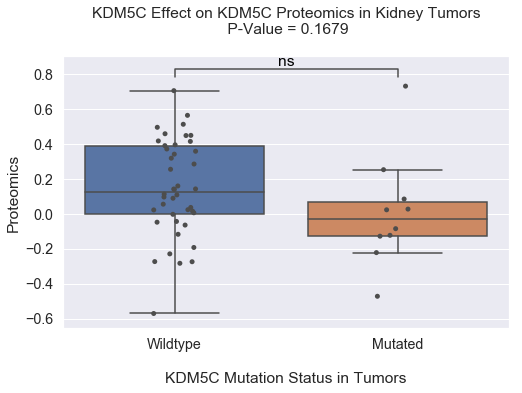

In [11]:
pval= 0.1679
cis_plot(prot_mut_status, gene, "proteomics", pval)

Proteomics: Missense and Truncation compared to wildtype

In [56]:
prot_mut_type = f.get_missense_truncation_comparison(cancer, 'proteomics', gene)
prot_wildtype = prot_mut_status.loc[prot_mut_status['binary_mutations'] == 'Wildtype'] # select all wildtype from binary_mutations
prot_mut_and_wildtype = prot_mut_type.append(prot_wildtype, sort=False) # use for graph

# compare missense and wildtype
prot_miss_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
prot_results_miss = al.wrap_ttest(prot_miss_wt, 'binary_mutations', prot_col_list,verbose=True)
print(prot_results_miss)
miss_pval = get_pval(prot_results_miss)

# compare truncation and wildtype
prot_trunc_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
prot_results_trunc = al.wrap_ttest(prot_trunc_wt, 'binary_mutations', prot_col_list)
print(prot_results_trunc)

trunc_pval = get_pval(prot_results_trunc)

Doing t-test comparison for missense and wildtype

KDM5C_proteomics :  0.26845034071862944
No significant comparisons.
None


Doing t-test comparison for truncation and wildtype

         Comparison   P_Value
0  KDM5C_proteomics  0.029263


In [57]:
pval_list=[miss_pval, trunc_pval]
pval_str_list = []
    
# pval annotation
bonferroni_cutoff = .05/ total_tests
for pval in pval_list:
    if isinstance(pval, float):
        if pval <= bonferroni_cutoff:
            pval_symbol = "*"
        else:
            pval_symbol = "ns"
        pval_str = str(pval)
        pval_str_list.append(pval_str)
    else:
        pval_symbol = "ns"
        pval_str = "> 0.05"
        pval_str_list.append(pval_str)

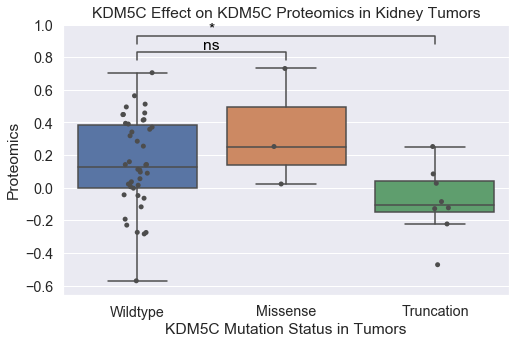

In [59]:
# Plots with all data for Tumor Samples
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
trans_cis_boxplot = sns.boxplot(data = prot_mut_and_wildtype, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Missense","Truncation"], showfliers = False)  
trans_cis_boxplot.set_title(gene + " Effect on " + gene +" Proteomics in Kidney Tumors")
trans_cis_boxplot = sns.stripplot(data = prot_mut_and_wildtype, x = 'binary_mutations',y = prot_col, jitter = True, 
                        color = ".3", order = ["Wildtype","Missense","Truncation"])
trans_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")


#pval annotations for missense
x1, x2 = 0, 1 # columns (first column: 0, see plt.xticks())
y, h = prot_mut_and_wildtype[gene+"_proteomics"].max() + .05, .05  
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color= '.3')
plt.text((x1+x2)*.5,y+h, 'ns', horizontalalignment='center', verticalalignment='bottom', color = "black")

#pval annotations for truncation
x3, x4 = 0, 2 # columns (first column: 0, see plt.xticks())
y, h = prot_mut_and_wildtype[gene+"_proteomics"].max() + .15, .05  
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, color= '.3')
plt.text((x1+x2)*.5,y+h, '*', ha = "center", va = 'bottom', color = "black")

plt.show()
plt.clf()
plt.close()

# Transcriptomics cis comparison

Transcriptomics: Mutated and Wildtype

In [60]:
trans_mut_status = f.format_cis_comparison_data(cancer, 'transcriptomics', gene)

trans_col_list = [gene+'_transcriptomics']
print("Doing t-test comparison for mutation status\n")
transcrpt_results = al.wrap_ttest(trans_mut_status, 'binary_mutations', trans_col_list)

if transcrpt_results is not None:
    # Adjust for multiple hypothesis testing
    pval_results = f.add_significance_col(transcrpt_results, total_tests)
    print(pval_results, '\n')
    # Create dataframe with all results
    all_comparisons = add_to_all_results(pval_results, gene, 'Transcriptomics', 'mutated/wildtype', all_comparisons)


Doing t-test comparison for mutation status

              Comparison   P_Value  Significant
0  KDM5C_transcriptomics  0.000038         True 



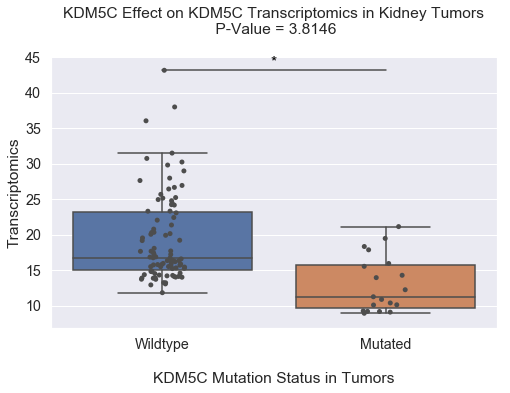

In [41]:
cis_plot(trans_mut_status, gene, 'transcriptomics', pval_results)

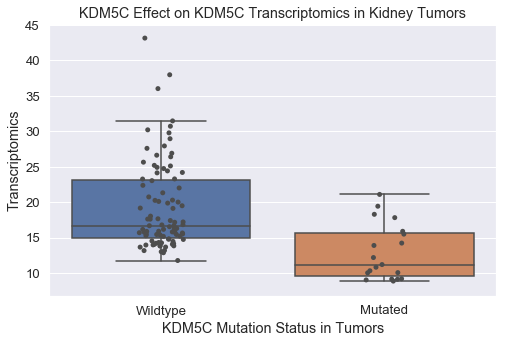

In [51]:
trans_col = gene+'_transcriptomics'

plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = trans_mut_status, x = 'binary_mutations',
                          y = trans_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors")
cis_boxplot = sns.stripplot(data = trans_mut_status, x = 'binary_mutations',y = trans_col, jitter = True, 
                        color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Transcriptomics")
plt.show()
plt.clf()
plt.close()

Transcriptomics: Missense and Truncation

In [10]:
# select all wildtype from earlier -add to mut_type binary column
trans_wildtype = trans_mut_status.loc[trans_mut_status['binary_mutations'] == 'Wildtype'] 
trans_mut_type = f.get_missense_truncation_comparison(cancer, 'transcriptomics', gene)
trans_mut_and_wildtype = trans_mut_type.append(trans_wildtype, sort=False) # use for graph


trans_col_list = [gene+'_transcriptomics']
# compare missense and wildtype
miss_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
results_prot_miss = al.wrap_ttest(miss_wt, 'binary_mutations', trans_col_list)
print(results_prot_miss)

# compare truncation and wildtype
trunc_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
results_prot_trunc = al.wrap_ttest(trunc_wt, 'binary_mutations', trans_col_list)
print(results_prot_trunc)

Doing t-test comparison for missense and wildtype

No significant comparisons.
None


Doing t-test comparison for truncation and wildtype

              Comparison   P_Value
0  KDM5C_transcriptomics  0.000027


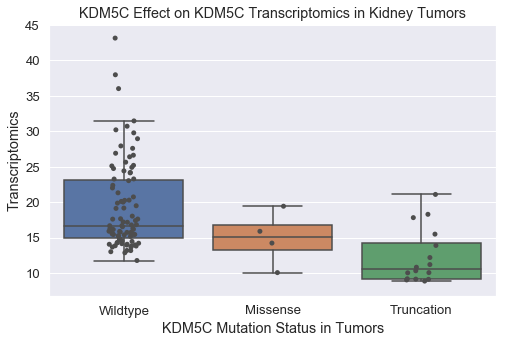

In [52]:
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
trans_cis_boxplot = sns.boxplot(data = trans_mut_and_wildtype, x = 'binary_mutations',
                          y = trans_col, order = ["Wildtype","Missense","Truncation"], showfliers = False)  
trans_cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors")
trans_cis_boxplot = sns.stripplot(data = trans_mut_and_wildtype, x = 'binary_mutations',y = trans_col, jitter = True, 
                        color = ".3", order = ["Wildtype","Missense","Truncation"])
trans_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Transcriptomics")
plt.show()
plt.clf()
plt.close()

# Phosphoproteomics cis comparison

Phosphoproteomics: Mutated and Wildtype

In [12]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = cancer.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
omics_and_mut = omics_and_mut.query('Sample_Status != "Normal"') # changed because warning with slice
#tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = omics_and_mut.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)
#omics_and_mut['binary_mutations'].value_counts()

In [13]:
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status\n")
phos_pval_results = al.wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
phos_pval_results

Doing t-test comparison for mutation status



C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,Comparison,P_Value
0,KDM5C-T1357_phosphoproteomics,5.945912e-09
1,KDM5C-S300_phosphoproteomics,1.957095e-05


Graph

In [14]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(only_phospho.columns)
phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
#sig_phospho_df.dropna(axis=0)

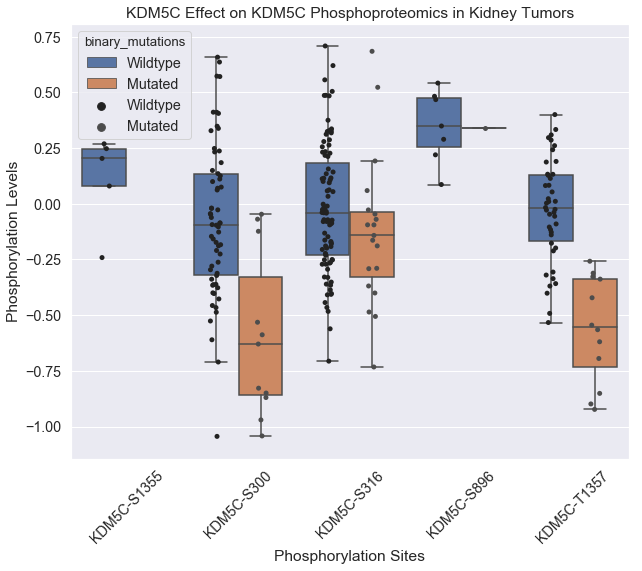

In [19]:
plt.rcParams['figure.figsize']=(10,8) #size of plot
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Kidney Tumors")
cis_boxplot = sns.stripplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels(),rotation = 45)
plt.show()
plt.clf()
plt.close()

Phosphoproteomics: Missense and Truncation

In [20]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = f.get_missense_truncation_comparison(cancer, 'phosphoproteomics', gene)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 

In [23]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
phos_results_miss = al.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
print(phos_results_miss)

Doing t-test comparison for missense and wildtype

                      Comparison   P_Value
0  KDM5C-T1357_phosphoproteomics  0.001026


In [41]:
# Create data frame with all significant phospho sites for missense comparison
sig_miss_col = list(phos_results_miss['Comparison'])
phos_miss_df = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = sig_miss_col, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_miss_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names

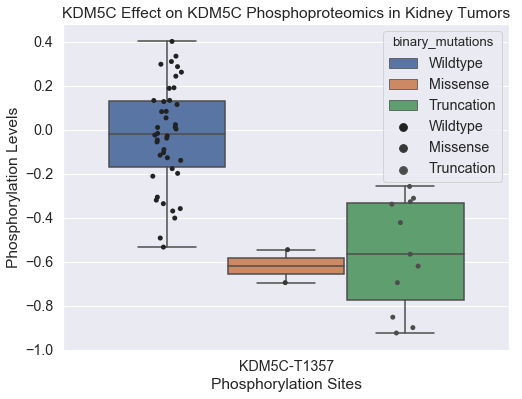

In [48]:
plt.rcParams['figure.figsize']=(8,6) #size of plot
sns.set(font_scale = 1.3)
phos_cis_boxplot = sns.boxplot(data = phos_miss_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Kidney Tumors")
phos_cis_boxplot = sns.stripplot(data = phos_miss_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge = True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels())
plt.show()
plt.clf()
plt.close()

In [34]:
# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc = al.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
print(phos_results_trunc)



Doing t-test comparison for truncation and wildtype

                      Comparison       P_Value
0  KDM5C-T1357_phosphoproteomics  1.790970e-08
1   KDM5C-S300_phosphoproteomics  2.977410e-05


In [36]:
# Create data frame with all significant phospho sites for missense comparison
sig_trunc_col = list(phos_results_trunc['Comparison'])
phos_trunc_df = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = sig_trunc_col, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_trunc_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names

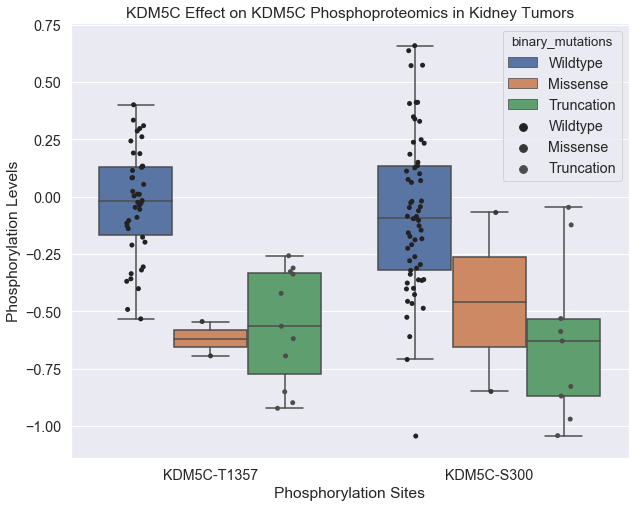

In [40]:
plt.rcParams['figure.figsize']=(10,8) #size of plot
sns.set(font_scale = 1.3)
phos_cis_boxplot = sns.boxplot(data = phos_trunc_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Kidney Tumors")
phos_cis_boxplot = sns.stripplot(data = phos_trunc_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge = True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels())
plt.show()
plt.clf()
plt.close()

# Analysis of Results

Significant cis comparisons: Truncation for proteomics, truncation for transcriptomics, Proteomics and Transcriptomics decreased for KDM5C with truncation mutations. 

No acetylproteomics for the kidney dataset.